In [1]:
# 查看数据集目录
!ls ./data

Data Dictionary.xls cs-test.csv         cs-training.csv     sampleEntry.csv


In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import scorecardpy as sc

import warnings
warnings.filterwarnings('ignore')

# 处理中文乱码
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft Yahei']
mpl.rcParams['font.serif'] = ['Microsoft Yahei']
# print(mpl.matplotlib_fname())

In [4]:
train_df = pd.read_csv('./data/cs-training.csv',encoding='utf-8').drop("Unnamed: 0", axis=1)
test_df= pd.read_csv('./data/cs-test.csv',encoding='utf-8').drop("Unnamed: 0", axis=1)
train_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## 变量的中文解释
- 'SeriousDlqin2yrs', 好坏客户
- 'RevolvingUtilizationOfUnsecuredLines', 可用额度比值
- 'age', 年龄
- 'NumberOfTime30-59DaysPastDueNotWorse',  逾期30-60天的笔数
- 'DebtRatio', 负债率
- 'MonthlyIncome', 月收入
- 'NumberOfOpenCreditLinesAndLoans', 信贷数量
- 'NumberOfTimes90DaysLate', 逾期90天的笔数
- 'NumberRealEstateLoansOrLines', 固定资产的贷款数量
- 'NumberOfTime60-89DaysPastDueNotWorse', 逾期60-90天的笔数
- 'NumberOfDependents', 家属数量

## 训练数据的正负样本比例
- Lr中balanced 方法进行权重设置
- 进行样本权重的设置
- SMOTE过采样的方法进行计算

In [5]:
train_df.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

<AxesSubplot:>

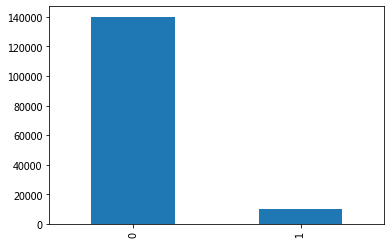

In [6]:
train_df.SeriousDlqin2yrs.value_counts().plot(kind = 'bar')

## 查看训练样本和测试样本的缺失情况
- 缺失的特征是年收入占比20%，可用随机森林进行预测填充
- 家庭的人数用中位数，查看变量的分布情况，确定填充平均值、中位数、或者众数
- 同时构造新的变量特征 缺失值、和平均人月收入

<AxesSubplot:title={'center':'训练特征缺失情况'}>

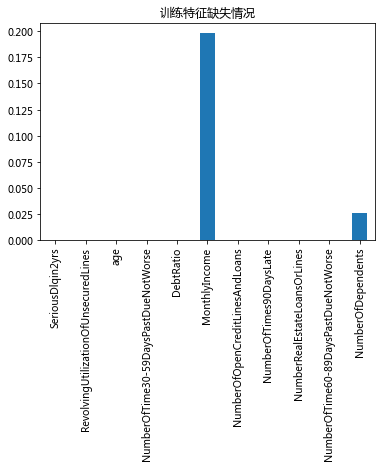

In [7]:
(train_df.isnull().sum()/train_df.shape[0]).plot(kind = 'bar',title = "训练特征缺失情况")

<AxesSubplot:title={'center':'测试特征缺失情况'}>

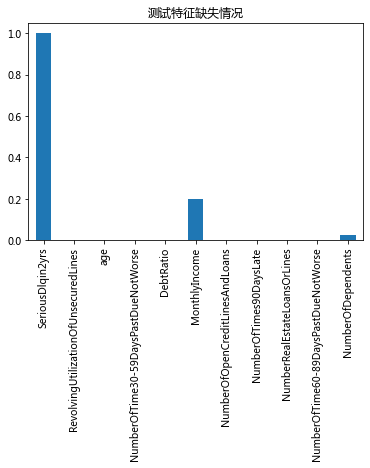

In [8]:
(test_df.isnull().sum()/test_df.shape[0]).plot(kind = 'bar',title = "测试特征缺失情况")

In [9]:
train_df['null_rate'] = train_df.isnull().sum(axis=1)
test_df['null_rate'] = test_df.isnull().sum(axis = 1)-1

<AxesSubplot:title={'center':'家庭成员'}>

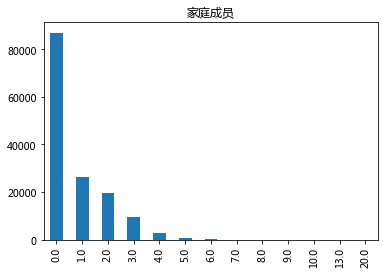

In [10]:
train_df.NumberOfDependents.value_counts().plot(kind = 'bar',title = '家庭成员')

In [11]:
train_df['NumberOfDependents'].fillna(value = train_df['NumberOfDependents'].median(),inplace=True)
test_df['NumberOfDependents'].fillna(value = test_df['NumberOfDependents'].median(),inplace=True)

In [12]:
from sklearn.ensemble import RandomForestRegressor
def handle_missing_value(df):
    process_df = df.iloc[:,[5,1,2,3,4,6,7,8,9]]
    know = process_df[process_df.MonthlyIncome.notnull()].values
    unknow = process_df[process_df.MonthlyIncome.isnull()].values
    x = know[:,1:]
    y = know[:,0]
    rf = RandomForestRegressor(random_state=0,n_estimators = 150,max_depth = 4,n_jobs = -1)
    rf.fit(x,y)
    predicted = rf.predict(unknow[:,1:]).round(0)
    print("predict_value:",predicted)
    df.loc[(df.MonthlyIncome.isnull()), 'MonthlyIncome'] = predicted
    return df

train_df = handle_missing_value(train_df)
test_df = handle_missing_value(test_df)

predict_value: [6991.   78. 6991. ...   78. 1691. 1691.]
predict_value: [1848.  410. 7383. ...  427.  410. 7383.]


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         150000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    150000 non-null  float64
 11  

In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      0 non-null       float64
 1   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 2   age                                   101503 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 4   DebtRatio                             101503 non-null  float64
 5   MonthlyIncome                         101503 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 7   NumberOfTimes90DaysLate               101503 non-null  int64  
 8   NumberRealEstateLoansOrLines          101503 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 10  NumberOfDependents                    101503 non-null  float64
 11  

## 此时训练额数据集合测试的数据集都已经没有缺失值

In [15]:
train_df['average_rate'] = round(train_df['MonthlyIncome']/(train_df['NumberOfDependents']+1).round(1),2)
test_df['average_rate'] = round(test_df['MonthlyIncome']/(test_df['NumberOfDependents']+1).round(1),2)

## 剔除常量值大于0.95的特征
## 剔除低方差的特征

In [17]:
constant_col_train = [col for col in train_df.columns if train_df[col].value_counts(dropna=False,normalize=True).max()>0.95]
constant_cols_test = [col for col in test_df.columns if test_df[col].value_counts(dropna=False,normalize=True).max()>0.95]

print(constant_col_train)
print(constant_cols_test)

[]
['SeriousDlqin2yrs']


In [18]:
train_df.mean()

SeriousDlqin2yrs                           0.066840
RevolvingUtilizationOfUnsecuredLines       6.048438
age                                       52.295207
NumberOfTime30-59DaysPastDueNotWorse       0.421033
DebtRatio                                353.005076
MonthlyIncome                           5844.098067
NumberOfOpenCreditLinesAndLoans            8.452760
NumberOfTimes90DaysLate                    0.265973
NumberRealEstateLoansOrLines               1.018240
NumberOfTime60-89DaysPastDueNotWorse       0.240387
NumberOfDependents                         0.737413
null_rate                                  0.224367
average_rate                            4054.182079
dtype: float64

In [19]:
test_df.mean()

SeriousDlqin2yrs                                NaN
RevolvingUtilizationOfUnsecuredLines       5.310000
age                                       52.405436
NumberOfTime30-59DaysPastDueNotWorse       0.453770
DebtRatio                                344.475020
MonthlyIncome                           6026.285312
NumberOfOpenCreditLinesAndLoans            8.453514
NumberOfTimes90DaysLate                    0.296691
NumberRealEstateLoansOrLines               1.013074
NumberOfTime60-89DaysPastDueNotWorse       0.270317
NumberOfDependents                         0.749150
null_rate                                  0.223924
average_rate                            4193.340354
dtype: float64

## 皮尔森系数绘图，观察多重共线的变量多变量分析,保留相关性低于阈值0.6的变量，删除IV值较小的变量

<AxesSubplot:>

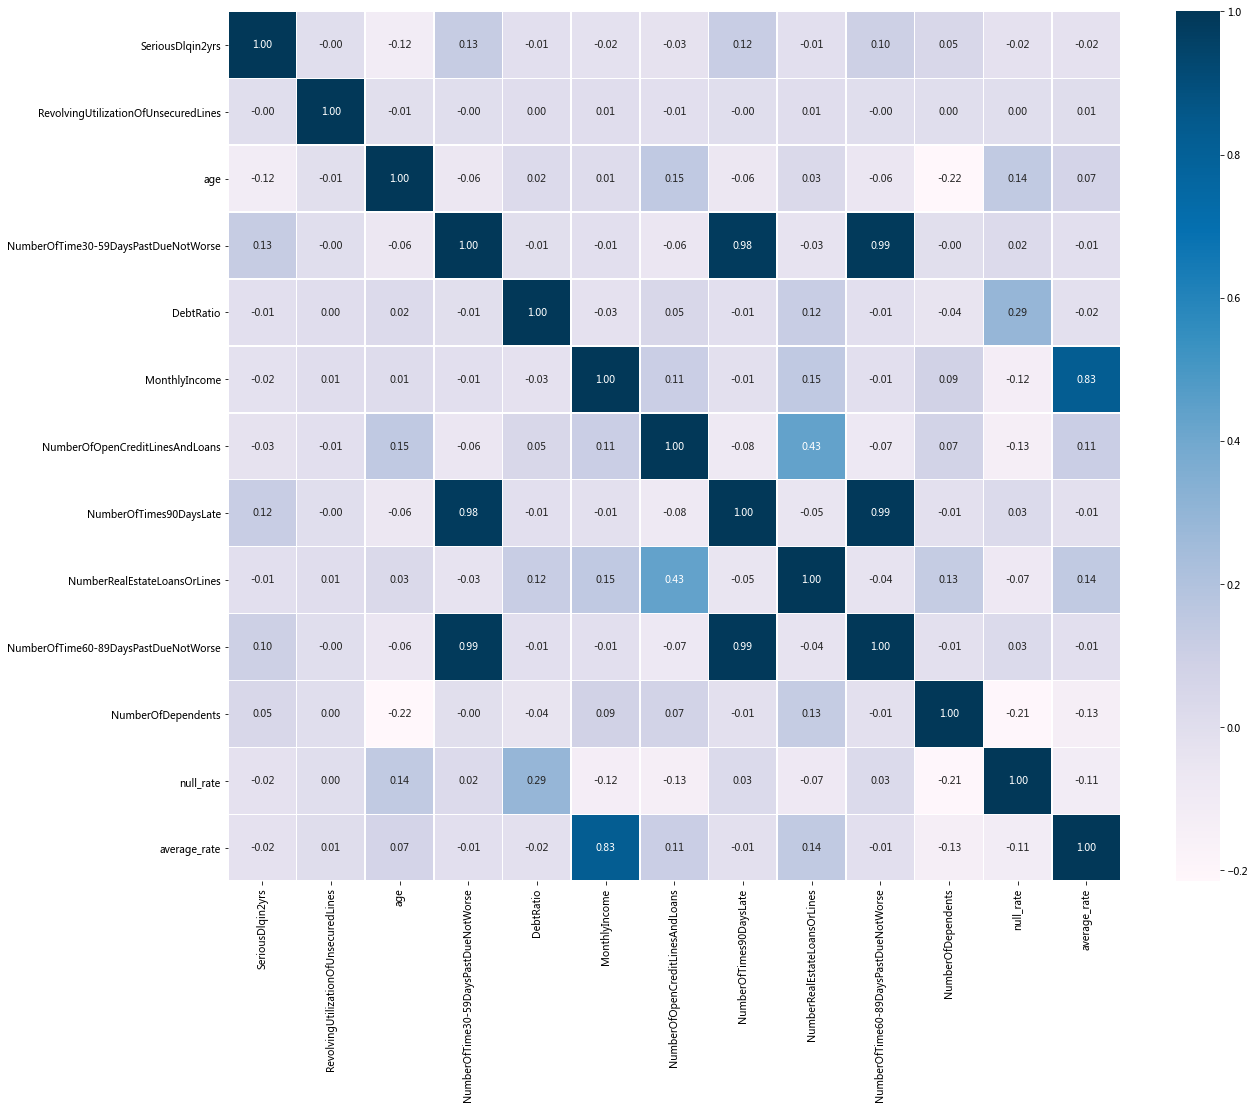

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
corr=train_df.corr()
fig1025,ax1025=plt.subplots(figsize=(20,16))
sns.heatmap(corr,cmap='PuBu',ax=ax1025,annot=True,fmt='.2f',linewidth=0.5)

#  将训练的数据划分为训练集和验证训练的数据上计算iv值，转化为woe，进一步的筛选变量